This notebook is an example notebook for processing VAMPIRES polarimetric imaging frames using the pyMuellerMat package to create a system Mueller matrix

In [1]:
from pyMuellerMat import common_mms as cmm
from pyMuellerMat import MuellerMat
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from vampires_utils import *
import astropy.units as u
from skimage.transform import rotate

## These astropy things will be needed to calculate parallactic angle
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroplan import Observer, FixedTarget

plt.style.use('dark_background')

#Some nicer printing options to avoid machine errors
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

## Let's build up a perfect Mueller Matrix

First some instrument offset terms

In [2]:
## Various Rotational Offsets - Defaults are GPI values
hwp_offset = 0 #Degrees - Related to the definition of in the instrument Q frame - in the NIR this is very close to zero
sky_offset = 0 #Degrees - Related to how the parallactic angle maps onto the instrument Q frame
imrot_offset = 0 #Degrees - Related to how the image rotator angle maps to the instrument Q frame

Now all the individual Mueller matrix components. For now we assume that we can remove the instrumental polarization in the data afterwards and that all the other components are ideal

In [3]:
wollaston_mm = cmm.WollastonPrism()
hwp_mm = cmm.Retarder() 
hwp_mm.properties['phi'] = 2*np.pi*0.5 #Make the HWP an ideal HWP
fast_hwp_mm = cmm.Retarder(name = "flc") 
fast_hwp_mm.properties['phi'] = 2*np.pi*0.5 #Make the fast switcher an ideal HWP
image_rotator = cmm.Retarder(name ="image_rotator")
image_rotator.properties['phi'] = 2*np.pi*0.5 #Image rotator is assumed to be ideal HWP for now. 
pupil_offset = cmm.Rotator(name="pupil_offset")
sky_mm = cmm.Rotator(name="sky_pa")
altitude_mm = cmm.Rotator(name="altitude")
m3_sign_flip = cmm.UV_Sign_Flip(name="M3")
#TODO: Include M3 sign-flip

Combine all the individual components into a system 

In [4]:
# sys_mm = MuellerMat.SystemMuellerMatrix([wollaston_mm,fast_hwp_mm,image_rotator,pupil_offset,hwp_mm,altitude_mm,sky_mm])
sys_mm = MuellerMat.SystemMuellerMatrix([wollaston_mm,fast_hwp_mm,image_rotator,hwp_mm,altitude_mm,sky_mm])
# sys_mm = MuellerMat.SystemMuellerMatrix([wollaston_mm,fast_hwp_mm,hwp_mm,altitude_mm,sky_mm]) #No image rotator

### Read in the files

In [5]:
# filelist = sorted(glob.glob("/home/shared/Data/Subaru/20220127/VAMPIRES/MWC480/Aligned_750/*.fits"))
filelist = sorted(glob.glob("/home/shared/Data/Subaru/Vampires/Reduced/20220127/mmb/CQ_Tau/750/*.fits"))
print("Found {} files".format(len(filelist)))

Found 108 files


Set up a bunch of arrays to hold the data and auxiliary info

In [6]:
npix = 256 #Hard code this here to set the size of the imaging arrays

# A bunch of empty ararys - with descriptions of what they will be. 
pas = np.zeros(len(filelist)) #The parallactic angles (with the offset correction)
fast_hwps = np.zeros(len(filelist)) #The state of the fast switcher
camera = np.zeros(len(filelist))
imrot_angle = np.zeros(len(filelist))
hwps = np.zeros(len(filelist)) #The HWPs (with the offset correction)
data = np.zeros([len(filelist),npix,npix]) #All the podc slices
altitudes = np.zeros(len(filelist)) #Telescope altitudes in degrees
measurement_matrix = np.zeros([len(filelist),4]) #The measurement matrix
stokes_cube = np.zeros([4,npix,npix]) #The Stokes cube determined through an interative solver with a loss function
stokes_cube_lstsq = np.zeros([4,npix,npix]) #The Stokes cube
rotation_angle = np.zeros(len(filelist))

In [7]:
#Set the observing site 
subaru = Observer.at_site('subaru')

#Read in the files and fill up the arrays
for i,filename in enumerate(filelist):
    with fits.open(filename) as hdu:

        #Gather a bunch of info to calculate the parallactic angle using astroplan
        mjd = hdu[0].header["MJD"]
        t = Time(mjd,format='mjd')
        ra = hdu[0].header['RA']
        dec = hdu[0].header['DEC']
        coordinates = SkyCoord(ra, dec, frame='icrs',unit=(u.hourangle, u.deg))
        target = FixedTarget(coord=coordinates)
        pa = subaru.parallactic_angle(t,target)
        pas[i] = pa.to(u.deg).value 
        
        
        #Read in the other header info
        hwps[i] = (hdu[0].header['U_HWPANG'])-(hwp_offset) #Applying the offset and sign convention like in the GPI DRP
        imrot_angle[i] = hdu[0].header['D_IMRANG']
        fast_hwps[i] = hdu[0].header['U_FLCSTT']
        camera[i] = hdu[0].header['U_CAMERA']
        altitudes[i] = hdu[0].header['ALTITUDE']
        rotation_angle[i] = hdu[0].header['D_IMRPAD']

        data[i,:,:] = np.mean(hdu[0].data,axis=0) # Just use the mean-collapsed data
        
        # Now read in the data - We're going to take the mean of each data file here. 
        # We're also going to flip camera 2's y axis b/c we need to. 
        if camera[i] == 1:
            data[i,:,:] = np.flip(np.mean(hdu[0].data,axis=0),axis=-2) # Just use the mean-collapsed data
        else: 
            data[i,:,:] = np.mean(hdu[0].data,axis=0)#[::-1,:] # Just use the mean-collapsed data


In [67]:
rotation_angle

array([  14.44 ,   14.44 ,   14.44 ,   14.44 ,   12.712,   12.712,
         12.712,   12.712,   11.225,   11.225,   11.225,   11.225,
          9.63 ,    9.63 ,    9.63 ,    9.63 ,    6.696,    6.696,
          6.696,    6.696,    4.955,    4.955,    4.955,    4.955,
          3.117,    3.117,    3.117,    3.117,    1.205,    1.205,
          1.205,    1.205,   -0.781,   -0.781,   -0.781,   -0.781,
         -2.873,   -2.873,   -2.873,   -2.873,   -5.136,   -5.136,
         -5.136,   -5.136,   -7.551,   -7.551,   -7.551,   -7.551,
         -9.909,   -9.909,   -9.909,   -9.909,  -12.446,  -12.446,
        -12.446,  -12.446,  -15.17 ,  -15.17 ,  -15.17 ,  -15.17 ,
        -92.094,  -92.094,  -92.094,  -92.094,  -93.392,  -93.392,
        -93.392,  -93.392,  -94.558,  -94.558,  -94.558,  -94.558,
        -95.683,  -95.683,  -95.683,  -95.683,  -96.769,  -96.769,
        -96.769,  -96.769,  -97.817,  -97.817,  -97.817,  -97.817,
        -98.748,  -98.748,  -98.748,  -98.748,  -99.677,  -99.

Align all the data to itself

In [90]:
data = shift_data_stack(data,data[0])
center = np.where(data[0] == np.max(data[0]))

rotated_data = copy.deepcopy(data)
for i in range(data.shape[0]):
    # rotated_data[i] = rotate(data[i],-pas[i]-imrot_angle[i]+39,center=(center[1][0],center[0][0]))
    # rotated_data[i] = rotate(data[i],pas[i]+imrot_angle[i],center=(center[1][0],center[0][0]))
    # rotated_data[i] = rotate(data[i],rotation_angle[i]+180+39,center=(center[1][0],center[0][0]))
    rotated_data[i] = rotate(data[i],-(rotation_angle[i]),center=(center[1][0],center[0][0]))


Build the Measurement Matrix - (i.e. how the sky Stokes vectors relates to the measured intensisty at the detector for any given configuration)

In [103]:
for i, filename in enumerate(filelist):
    if camera[i] == 1:
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'o'
    else: 
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'e'
    
    if fast_hwps[i] == 1:
        sys_mm.master_property_dict['flc']['theta'] = 0
    else: 
        sys_mm.master_property_dict['flc']['theta'] = 45

    sys_mm.master_property_dict['Retarder']['theta'] = hwps[i]
    sys_mm.master_property_dict['sky_pa']['pa'] = pas[i]
    sys_mm.master_property_dict['image_rotator']['theta'] = imrot_angle[i]
    sys_mm.master_property_dict['altitude']['pa'] = altitudes[i]
    measurement_matrix[i] = sys_mm.evaluate()[0]

Solve for the input stokes values at each pixel

In [104]:
for i in np.arange(0,256):
    for j in np.arange(0,256):

        # this_pixel = data[:,i,j]
        this_pixel = rotated_data[:,i,j]
        if any(np.isnan(data[:,i,j])):
            stokes_cube[:,i,j] = np.nan
        else:
            #This version just does the simple linear inversion and is most similar to the GPI pipeline
            stokes_cube_lstsq[:,i,j] = np.linalg.lstsq(measurement_matrix,this_pixel)[0]
            

/tmp/ipykernel_2428069/1177479990.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  stokes_cube_lstsq[:,i,j] = np.linalg.lstsq(measurement_matrix,this_pixel)[0]


Make a plot of it

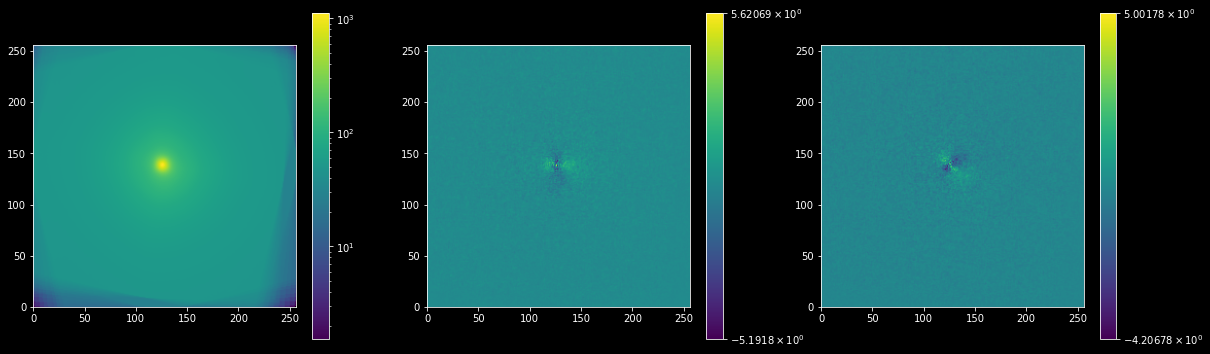

In [105]:
from matplotlib.colors import LogNorm, SymLogNorm
fig,axes = plt.subplots(1,3,figsize=(20,6))
axes = axes.flatten()
im0 = axes[0].imshow(stokes_cube_lstsq[0],norm=LogNorm())
im1 = axes[1].imshow(stokes_cube_lstsq[1],norm=SymLogNorm(linthresh=100))
im2 = axes[2].imshow(stokes_cube_lstsq[2],norm=SymLogNorm(linthresh=100))


low = 80
high = 180

low = 0
high = 256


axes[0].set_xlim(low,high)
axes[0].set_ylim(low,high)
axes[1].set_xlim(low,high)
axes[1].set_ylim(low,high)
axes[2].set_xlim(low,high)
axes[2].set_ylim(low,high)
plt.colorbar(im0,ax=axes[0])
plt.colorbar(im1,ax=axes[1])
plt.colorbar(im2,ax=axes[2])

Calculate the instrumental polarization

In [106]:
#Define a set of weights for the image.
weights = np.sqrt(stokes_cube_lstsq[0])
weights[~np.isfinite(weights)] = 0. 

#We know the center is full of junk, so let's exclude a region at the center. 
exclusion_region_size = 10
center_pix = np.where(stokes_cube_lstsq[0] == np.max(stokes_cube_lstsq[0]))
y,x = np.indices(stokes_cube_lstsq[0].shape)
x -= center_pix[1]
y -= center_pix[0]
radial_distance = np.sqrt(x**2+y**2)
weights[radial_distance < exclusion_region_size] = 0


#Choose the region over which you want to calculate the instrumental polarization 
ylow = 80
yhigh = 180
xlow = 80
xhigh = 180

# ylow = 115
# yhigh = 135
# xlow = 115
# xhigh = 135

#Calculate the instrumental polarization using weights
ipq = np.average((stokes_cube_lstsq[1]/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])
ipu = np.average((stokes_cube_lstsq[2]/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])

#Calculate the instrumental polarization without weights
# ipq = np.median((stokes_cube_lstsq[1]/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh])
# ipu = np.median((stokes_cube_lstsq[2]/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh])

/tmp/ipykernel_2428069/2794843985.py:27: RuntimeWarning: invalid value encountered in true_divide
  ipq = np.average((stokes_cube_lstsq[1]/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])
/tmp/ipykernel_2428069/2794843985.py:28: RuntimeWarning: invalid value encountered in true_divide
  ipu = np.average((stokes_cube_lstsq[2]/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])


In [107]:
center_pix

(array([138]), array([126]))

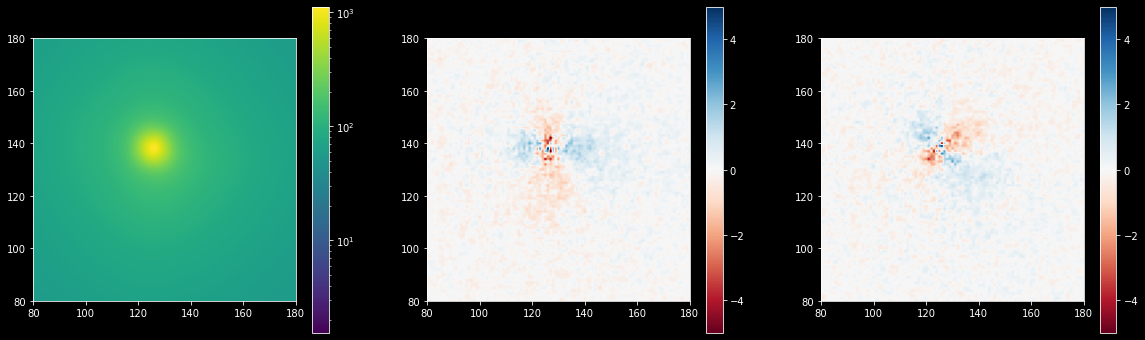

In [108]:
from matplotlib.colors import LogNorm, SymLogNorm
fig,axes = plt.subplots(1,3,figsize=(20,6))

vmin = -30
vmax = 30

axes = axes.flatten()
im0 = axes[0].imshow(stokes_cube_lstsq[0],norm=LogNorm())
im1 = axes[1].imshow(stokes_cube_lstsq[1]-ipq*stokes_cube_lstsq[0],cmap = 'RdBu',vmin=-5,vmax=5)#,vmin=vmin,vmax=vmax)
im2 = axes[2].imshow(stokes_cube_lstsq[2]-ipu*stokes_cube_lstsq[0],cmap = 'RdBu',vmin=-5,vmax=5)#,vmin=vmin,vmax=vmax)


low = 80
high = 180

axes[0].set_xlim(low,high)
axes[0].set_ylim(low,high)
axes[1].set_xlim(low,high)
axes[1].set_ylim(low,high)
axes[2].set_xlim(low,high)
axes[2].set_ylim(low,high)
plt.colorbar(im0,ax=axes[0])
plt.colorbar(im1,ax=axes[1])
plt.colorbar(im2,ax=axes[2])

After subtracting the instrumental polarization it looks like there is a background polarization level. Let's subtract that off and then recalculate the instrumental polarization. 

In [99]:
#We'll do this background subraction thing a couple times. 
iterations = 10
for i in range(iterations):
    q_background = np.median(stokes_cube_lstsq[1]-ipq*stokes_cube_lstsq[0])
    u_background = np.median(stokes_cube_lstsq[2]-ipu*stokes_cube_lstsq[0])

    #Re-estimate the ips
    ipq = np.average(((stokes_cube_lstsq[1]-q_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])
    ipu = np.average(((stokes_cube_lstsq[2]-u_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])

    # ipq = np.average(((stokes_cube_lstsq[1]-q_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh])
    # ipu = np.average(((stokes_cube_lstsq[2]-u_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh])

ipq_wo_bkg = np.average(((stokes_cube_lstsq[1])/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])
ipu_wo_bkg = np.average(((stokes_cube_lstsq[2])/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])


# ipq = np.median(((stokes_cube_lstsq[1]-q_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh])
# ipu = np.median(((stokes_cube_lstsq[2]-u_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh])

/tmp/ipykernel_2428069/354377753.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ipq = np.average(((stokes_cube_lstsq[1]-q_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])
/tmp/ipykernel_2428069/354377753.py:9: RuntimeWarning: divide by zero encountered in true_divide
  ipu = np.average(((stokes_cube_lstsq[2]-u_background)/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])
/tmp/ipykernel_2428069/354377753.py:14: RuntimeWarning: invalid value encountered in true_divide
  ipq_wo_bkg = np.average(((stokes_cube_lstsq[1])/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])
/tmp/ipykernel_2428069/354377753.py:15: RuntimeWarning: invalid value encountered in true_divide
  ipu_wo_bkg = np.average(((stokes_cube_lstsq[2])/stokes_cube_lstsq[0])[ylow:yhigh,xlow:xhigh],weights = weights[ylow:yhigh,xlow:xhigh])


In [100]:
print("Q Background Intensity = {}".format(q_background))
print("U Background Intensity = {}".format(u_background))
print("Instrumental Q = {:.3f}%".format(ipq*100))
print("Instrumental U = {:.3f}%".format(ipu*100))
print("Instrumental Q without subtracting background = {:.3f}%".format(ipq_wo_bkg*100))
print("Instrumental U without subtracting background = {:.3f}%".format(ipu_wo_bkg*100))

Q Background Intensity = 0.044924721305617796
U Background Intensity = 0.014843014124849898
Instrumental Q = -0.089%
Instrumental U = -0.030%
Instrumental Q without subtracting background = -0.035%
Instrumental U without subtracting background = -0.012%


In [101]:
#Plot 

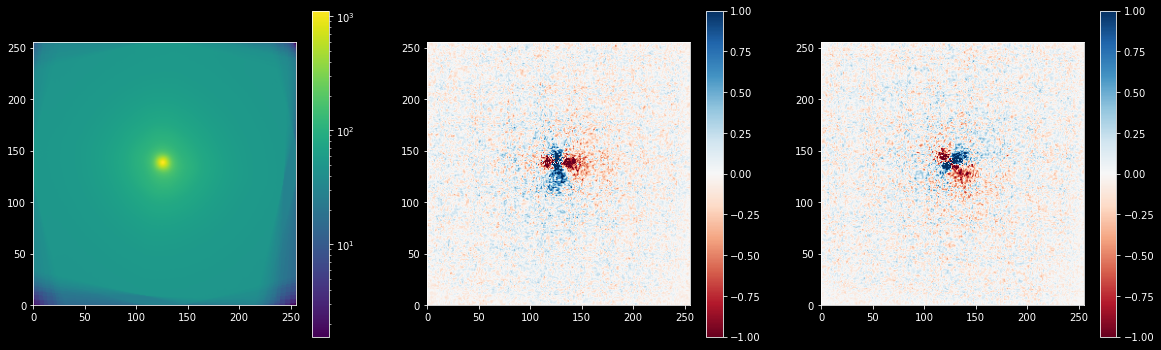

In [102]:
from matplotlib.colors import LogNorm, SymLogNorm
fig,axes = plt.subplots(1,3,figsize=(20,6))

vmin = -1
vmax = 1

axes = axes.flatten()
im0 = axes[0].imshow(stokes_cube_lstsq[0],norm=LogNorm())

finalq = stokes_cube_lstsq[1]-ipq*stokes_cube_lstsq[0]-q_background
im1 = axes[1].imshow(finalq,vmin=vmin,vmax=vmax,
cmap = 'RdBu')

finalu = stokes_cube_lstsq[2]-ipu*stokes_cube_lstsq[0]-u_background
im2 = axes[2].imshow(finalu,vmin=vmin,vmax=vmax
,
cmap = 'RdBu')


low = 80
high = 180

low = 0
high = 255


axes[0].set_xlim(low,high)
axes[0].set_ylim(low,high)
axes[1].set_xlim(low,high)
axes[1].set_ylim(low,high)
axes[2].set_xlim(low,high)
axes[2].set_ylim(low,high)

plt.colorbar(im0,ax=axes[0])
plt.colorbar(im1,ax=axes[1])
plt.colorbar(im2,ax=axes[2])

(80.0, 180.0)

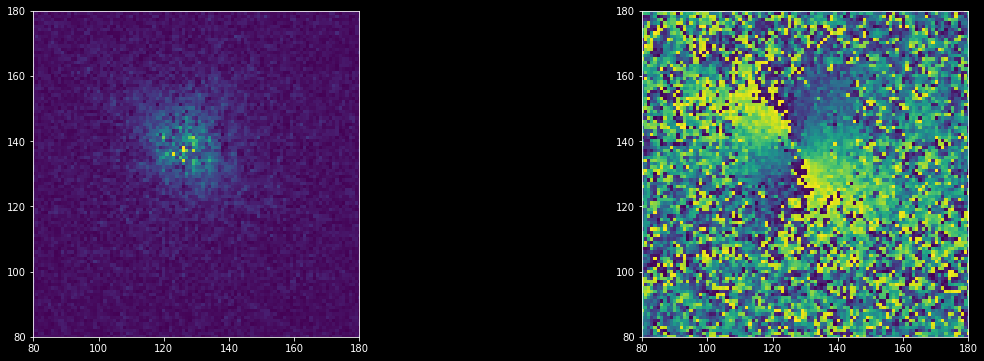

In [89]:
p = np.sqrt(finalq**2+finalu**2)
theta = 0.5*np.arctan2(finalu,finalq)

fig,axes = plt.subplots(1,2,figsize=(20,6))
axes[0].imshow(p,vmin=0,vmax=5)
axes[0].set_xlim(80,180)
axes[0].set_ylim(80,180)
# axes[0].colorbar()

axes[1].imshow(theta)
axes[1].set_xlim(80,180)
axes[1].set_ylim(80,180)
# axes[0].colorbar()



/tmp/ipykernel_2428069/3528099458.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(p/stokes_cube_lstsq[0])


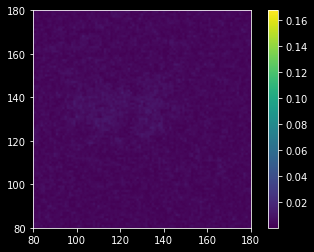

In [45]:
plt.imshow(p/stokes_cube_lstsq[0])
plt.xlim(80,180)
plt.ylim(80,180)
plt.colorbar()

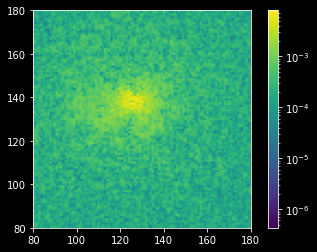

In [46]:
from matplotlib.colors import LogNorm
plt.imshow(p/np.max(stokes_cube_lstsq[0]),norm=LogNorm())
plt.xlim(80,180)
plt.ylim(80,180)
plt.colorbar()